# Importing Libraries

In [ ]:

import pandas as pd
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model




In [3]:
# uploading files
from google.colab import files
uploaded = files.upload()

Saving assignment.csv to assignment (7).csv


# Reading Input files

In [0]:
# reading the input file
tf = pd.read_csv("assignment.csv")

In [5]:
tf.head()

,unique_id,raw_text,review_text
0,0,Spiritually and mentally inspiring! A book tha...,Menginspirasi secara spiritual dan mental! Buk...
1,1,This is one my must have books,Ini adalah salah satu yang harus saya miliki buku
2,2,It is a masterpiece of spirituality,Itu adalah mahakarya spiritualitas
3,3,"I'll be the first to admit, its literary qual...","Saya akan menjadi yang pertama mengakui, kuali..."
4,4,"It is rather simplistically written, but the ...","Ini ditulis agak sederhana, tetapi pesan di ba..."


# Cleaning texts

In [0]:
# Remove punctuation
# cleaning the text using regular expressions, deleting everything other than alphabets
tf['raw_text'] = tf['raw_text'].str.replace("[^a-zA-Z]", " ")
tf['review_text'] = tf['review_text'].str.replace("[^a-zA-Z]", " ")

In [0]:

tf1 = tf[['raw_text','review_text']]

#tf1

In [8]:
tf1.shape

(53757, 2)

In [0]:
# considering part of dataset to save time and memory
tf1 = tf1.iloc[:18000,:]

In [10]:
tf1.shape

(18000, 2)

# Histogram representing length of Indonesian and English texts

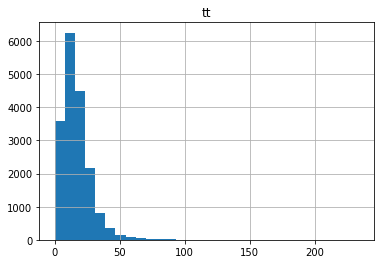

In [11]:

t_len=[]
for text in tf1['raw_text']:
    word=word_tokenize(text)
    #print(word)
    l=len(word)
   # print(l)
    t_len.append(l)
    #print(t_len)
#MAX_TEXT_LEN=np.max(len(t_len))
#MAX_TEXT_LEN
df = pd.DataFrame.from_dict({'tt':t_len})
#length_df = pd.Dataframe({'tt':t_len})
df.hist(bins = 30)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


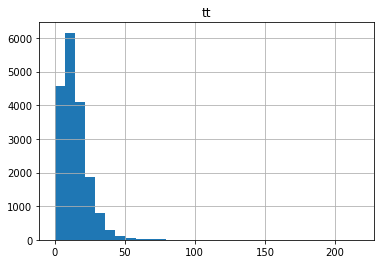

In [12]:
#result = tf['review_text'].to_string(index = False)
tf1['review_text'] = tf1['review_text'].astype(str)
r_len=[]
for text  in  tf1['review_text']:
    tokens = word_tokenize(text)
    #print(tokens)
   # words = [word for word in tokens if word.isalpha()]
    l=len( tokens)
    r_len.append(l)
   # print(r_len)    
df = pd.DataFrame.from_dict({'tt':r_len})
#length_df = pd.Dataframe({'tt':t_len})
df.hist(bins = 30)
plt.show()


# Building tokenizer for Indonesian and English texts 

In [0]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [14]:
# prepare english tokenizer
eng_tokenizer = tokenization(tf1['raw_text'])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 13378


In [15]:
# prepare indonesian tokenizer
indonesian_tokenizer = tokenization(tf1['review_text'])
indonesian_vocab_size = len(indonesian_tokenizer.word_index) + 1
print('Indonesian Vocabulary Size: %d' % indonesian_vocab_size)

Indonesian Vocabulary Size: 11077


# Padding sequences for considering same length

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

# Train test split

In [0]:

# split data into train and test set
#X_train, X_val, Y_train, Y_val = train_test_split(tf1['review_text'],tf1['raw_text'], test_size=0.2, random_state = 12)
train,test = train_test_split(tf1, test_size=0.2, random_state = 12)

# Data preparation for modelling

In [0]:
# frequency of words of length more than 50 is less so considering 50 as length
indonesian_length = 50
eng_length = 50

# prepare training data
trainX = encode_sequences(indonesian_tokenizer, indonesian_length, train['review_text'])
trainY = encode_sequences(eng_tokenizer, eng_length, train['raw_text'])

# prepare validation data
testX = encode_sequences(indonesian_tokenizer, indonesian_length, test['review_text'])
testY = encode_sequences(eng_tokenizer, eng_length, test['raw_text'])


# Building the model

In [0]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [0]:

# model compilation
model = define_model(indonesian_vocab_size, eng_vocab_size, indonesian_length, eng_length, 256)

In [0]:

rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

# Model Training

In [25]:

filename = 'model.1000'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1],1),
                    epochs=30, batch_size=256, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)


Train on 11520 samples, validate on 2880 samples
Epoch 1/30
11520/11520 [==============================] - 41s 4ms/step - loss: 2.1750 - val_loss: 2.2909

Epoch 00001: val_loss improved from inf to 2.29094, saving model to model.1000
Epoch 2/30
11520/11520 [==============================] - 39s 3ms/step - loss: 2.1710 - val_loss: 2.3630

Epoch 00002: val_loss did not improve from 2.29094
Epoch 3/30
11520/11520 [==============================] - 39s 3ms/step - loss: 2.1479 - val_loss: 2.2895

Epoch 00003: val_loss improved from 2.29094 to 2.28949, saving model to model.1000
Epoch 4/30
11520/11520 [==============================] - 39s 3ms/step - loss: 2.1454 - val_loss: 2.3291

Epoch 00004: val_loss did not improve from 2.28949
Epoch 5/30
11520/11520 [==============================] - 39s 3ms/step - loss: 2.1298 - val_loss: 2.3281

Epoch 00005: val_loss did not improve from 2.28949
Epoch 6/30
11520/11520 [==============================] - 39s 3ms/step - loss: 2.1165 - val_loss: 2.2641



# Plotting loss for training and validation data

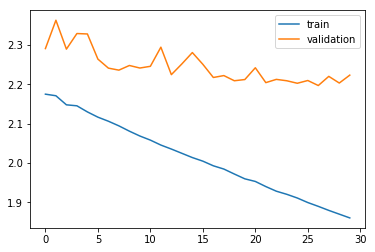

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

# Predicting the output

In [27]:

model = load_model('model.1000')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))
preds

array([[ 2, 16,  9, ...,  0,  0,  0],
       [ 9, 99,  8, ...,  0,  0,  0],
       [ 1,  8,  8, ...,  0,  0,  0],
       ...,
       [ 6,  0,  0, ...,  0,  0,  0],
       [38, 13,  5, ...,  0,  0,  0],
       [ 2,  8,  4, ...,  0,  0,  0]])

# Output integer to texts

In [0]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [0]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test['raw_text'], 'predicted' : preds_text})


# Actual vs Predicted texts

In [31]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
796,The book makes one feel good and inspired t...,it is a the ...
17003,I am left handed so holding things in my lef...,i to the and the ...
6927,It was very frustrating as I tried to enunc...,it is a the to ...
8922,This bra works fine but I didn t find it to ...,this is a and i ...
9775,I am very happy with Amazon Prime delivery,i m this ...
4200,Thus the story of Jacob joining the circus whe...,the ...
6965,And it is FUN to do I m enjoying it immensely,it was a it i it ...
15389,It is an ok device but does not truly shine a...,it is a i to ...
16525,kindle can t,i you t you ...
6587,Clear your schedule,the ...


# Conclusion 